In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd




## Get Actuals

In [5]:
year_df = pd.read_parquet("/Users/kristianertresvag/Documents/Handelshøyskolen BI/Master/4. semester/Master Thesis/Master Thesis/M3 Data/M3_yearly_processed.parquet")
quart_df = pd.read_parquet("/Users/kristianertresvag/Documents/Handelshøyskolen BI/Master/4. semester/Master Thesis/Master Thesis/M3 Data/M3_quarter_processed.parquet")
month_df = pd.read_parquet("/Users/kristianertresvag/Documents/Handelshøyskolen BI/Master/4. semester/Master Thesis/Master Thesis/M3 Data/M3_month_processed.parquet")


def get_actuals (df):
    # Sort the dataframe by Series and Date
    df_sorted = df.sort_values(by=['Series', 'Date'])
    
    # Define a function that gets the last `n` entries for each group
    def last_n_entries(group):
        # `NF` is assumed to be the same for all rows in the group, so we take the first one
        n = group['NF'].iloc[0]
        return group.tail(n)
    
    # Apply the function to each group and concatenate the results
    actuals_df = df_sorted.groupby('Series').apply(last_n_entries).reset_index(drop=True)
    
    return actuals_df

actuals_year_df = get_actuals(year_df)
actuals_quart_df = get_actuals(quart_df)
actuals_month_df = get_actuals(month_df)

actuals_df = pd.concat([actuals_year_df, 
                        actuals_quart_df,
                        actuals_month_df],
                        ignore_index=True)



## Merge

In [6]:
forecasts_df = pd.read_parquet("/Users/kristianertresvag/Documents/Handelshøyskolen BI/Master/4. semester/Master Thesis/Master Thesis/Analysis/complete_forecast_data.parquet")

results_df = pd.merge(forecasts_df, actuals_df[['Series', 'Date', 'Value', 'Category', 'NF']], how='left', on=['Series', 'Date'])
results_df['Category'] = results_df['Category'].str.strip()

results_df.rename(columns={'Value': 'Actual'}, inplace=True)
results_df.drop(['SINGLE'], axis=1, inplace=True)


#results_df.to_parquet('results.parquet', index=False, compression='snappy', engine='pyarrow')
results_df.to_csv('results.csv')

display(results_df)


,Series,Date,TimeGPT,Chronos,Moirai,ForecastPeriod,ARARMA,Auto-ANN,AutoBox1,AutoBox2,...,PP-Autocast,RBF,ROBUST-Trend,SMARTFCS,THETA,THETAsm,WINTER,Actual,Category,NF
0,1,1989-01-01,5121.754395,5471.703660,5075.040039,1,5553.26,5453.28,5442.92,4930.25,...,5475.80,5550.22,5204.32,5259.00,5414.60,5163.08,5406.43,5379.75,MICRO,6
1,1,1990-01-01,4974.531738,5847.765768,5983.503906,2,6246.45,6003.49,5969.23,5479.36,...,6014.62,6152.23,5471.66,5675.00,5934.47,5390.88,5875.96,6158.68,MICRO,6
2,1,1991-01-01,4750.660156,6195.623217,5960.694336,3,7026.18,6587.93,6495.55,5472.61,...,6553.43,6648.95,5738.99,6091.00,6331.96,5155.17,6345.48,6876.58,MICRO,6
3,1,1992-01-01,4366.261719,6195.623217,6046.625977,4,7903.23,7206.76,7021.87,6021.72,...,7092.24,6965.22,6006.32,6507.00,6822.35,5147.46,6815.00,7851.91,MICRO,6
4,1,1993-01-01,3914.425781,5866.568873,7204.881348,5,8889.77,7860.01,7548.18,6014.98,...,7631.05,7038.06,6273.66,6923.00,7140.76,5152.92,7284.53,8407.84,MICRO,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35617,2829,1988-07-01,1437.689209,1259.141011,1307.136963,14,1335.28,1139.87,1254.13,1204.10,...,1384.45,1371.58,1223.93,1170.98,1226.58,1452.61,1193.75,1282.50,OTHER,18
35618,2829,1988-08-01,1442.109741,1243.785633,1468.140381,15,1316.26,1116.26,1234.02,1182.42,...,1380.21,1355.06,1203.67,1147.83,1207.17,1451.93,1171.28,1261.30,OTHER,18
35619,2829,1988-09-01,1439.912842,1243.785633,1361.496338,16,1307.62,1091.50,1213.86,1160.74,...,1376.36,1345.82,1183.41,1124.68,1187.85,1448.36,1148.82,1263.40,OTHER,18
35620,2829,1988-10-01,1437.093018,1243.785633,1473.072998,17,1293.64,1066.18,1193.64,1139.06,...,1372.85,1336.08,1163.14,1101.53,1168.63,1458.19,1126.35,1257.10,OTHER,18


## Calculate Metrics

In [7]:
forecast_cols = [col for col in results_df.columns if col not in ['Series', 'Date', 'Naive2', 'Actual', 'ForecastPeriod', 'NF', 'Category']]

def calculate_mase_per_series(df, actual_col, forecast_cols, benchmark_col):
    results = {}

    # Calculate the MAE of the Naive2 benchmark per Series
    df['AbsErrorBenchmark'] = abs(df[actual_col] - df[benchmark_col])
    benchmark_mae = df.groupby('Series')['AbsErrorBenchmark'].mean()

    for series in df['Series'].unique():
        series_df = df[df['Series'] == series].copy()
        series_mase = {}
        for forecast_col in forecast_cols:
            # Calculate the MAE for the forecast method
            series_df['AbsErrorForecast'] = abs(series_df[actual_col] - series_df[forecast_col])
            forecast_mae = series_df['AbsErrorForecast'].mean()
            # Calculate MASE
            series_mase[forecast_col] = forecast_mae / benchmark_mae[series]
        results[series] = series_mase
    
    # Cleanup the temporary columns
    df.drop('AbsErrorBenchmark', axis=1, inplace=True)
    
    return results

# Assuming the actual column name is 'Actual'. If not, please replace 'Actual' with the actual column name.
mase_results = calculate_mase_per_series(results_df, 'Actual', forecast_cols, 'NAIVE2')

# Print the results
mase_results


{1: {'TimeGPT': 1.2158037233163284,
  'Chronos': 0.6058507226523364,
  'Moirai': 0.41846966540788366,
  'ARARMA': 0.12580698058883105,
  'Auto-ANN': 0.16319499916601157,
  'AutoBox1': 0.23962986396487257,
  'AutoBox2': 0.6578838651739798,
  'AutoBox3': 0.47881071136750886,
  'B-J auto': 0.20341013299476457,
  'COMB S-H-D': 0.5044841834267845,
  'DAMPEN': 0.22059944414846266,
  'Flors-Pearc1': 0.22425984405471808,
  'Flors-Pearc2': 0.7594531006423468,
  'ForcX': 0.8540668021223421,
  'ForecastPro': 0.20341013299476457,
  'HOLT': 0.3098552097533717,
  'NAIVE2': 1.0,
  'PP-Autocast': 0.2171797396407727,
  'RBF': 0.3525617520935925,
  'ROBUST-Trend': 0.6048935767406606,
  'SMARTFCS': 0.4247900777192773,
  'THETA': 0.32755547078823516,
  'THETAsm': 0.8878823942576552,
  'WINTER': 0.3098552097533717},
 2: {'TimeGPT': 1.5355240620814476,
  'Chronos': 1.6447125841789862,
  'Moirai': 1.079225639880265,
  'ARARMA': 0.7707722150378717,
  'Auto-ANN': 0.577097727692592,
  'AutoBox1': 0.985089599113

In [8]:
categories_dict = {
    'NAIVE2': 'Naive/Simple',
    'SINGLE': 'Naive/Simple',
    'HOLT': 'Explicit Trend Models',
    'ROBUST-Trend': 'Explicit Trend Models',
    'WINTER': 'Explicit Trend Models',
    'DAMPEN': 'Explicit Trend Models',
    'PP-Autocast': 'Explicit Trend Models',
    'THETAsm': 'Explicit Trend Models',
    'COMB S-H-D': 'Explicit Trend Models',
    'THETA': 'Decomposition',
    'B-J auto': 'ARIMA/ARARMA Models',
    'AutoBox1': 'ARIMA/ARARMA Models',
    'AutoBox2': 'ARIMA/ARARMA Models',
    'AutoBox3': 'ARIMA/ARARMA Models',
    'AAM1': 'ARIMA/ARARMA Models',
    'AAM2': 'ARIMA/ARARMA Models',
    'ARARMA': 'ARIMA/ARARMA Models',
    'ForecastPro': 'Expert Systems',
    'SMARTFCS': 'Expert Systems',
    'RBF': 'Expert Systems',
    'Flors-Pearc1': 'Expert Systems',
    'Flors-Pearc2': 'Expert Systems',
    'ForcX': 'Expert Systems',
    'Auto-ANN': 'Neural Networks',
    'TimeGPT': 'Foundation Models',
    'Chronos': 'Foundation Models',
    'Moirai': 'Foundation Models'
}

In [9]:
mase_df = pd.DataFrame.from_dict(mase_results, orient='index')

median_mase = mase_df.median().sort_values()

median_mase_df = pd.DataFrame(median_mase, columns=['MedianMASE'])

median_mase_df = median_mase_df.reset_index()
median_mase_df.columns = ['Method', 'MedianMASE']

median_mase_df['Category'] = median_mase_df['Method'].map(categories_dict)


In [10]:
color_map = {
    'Foundation Models': '#17a2b8',  # Vivid Turquoise
    'Naive/Simple': '#c0c0c0',       # Soft Gray
    'ARIMA/ARARMA Models': '#aec6cf', # Gentle Blue
    'Explicit Trend Models': '#7393B3', # Dusty Blue
    'Decomposition': '#93e9be',        # Seafoam Green
    'Expert Systems': '#87cefa',       # Light Sky Blue
    'Neural Networks': '#e6e6fa',      # Pale Lavender
}

category_colors = median_mase_df['Category'].map(color_map)



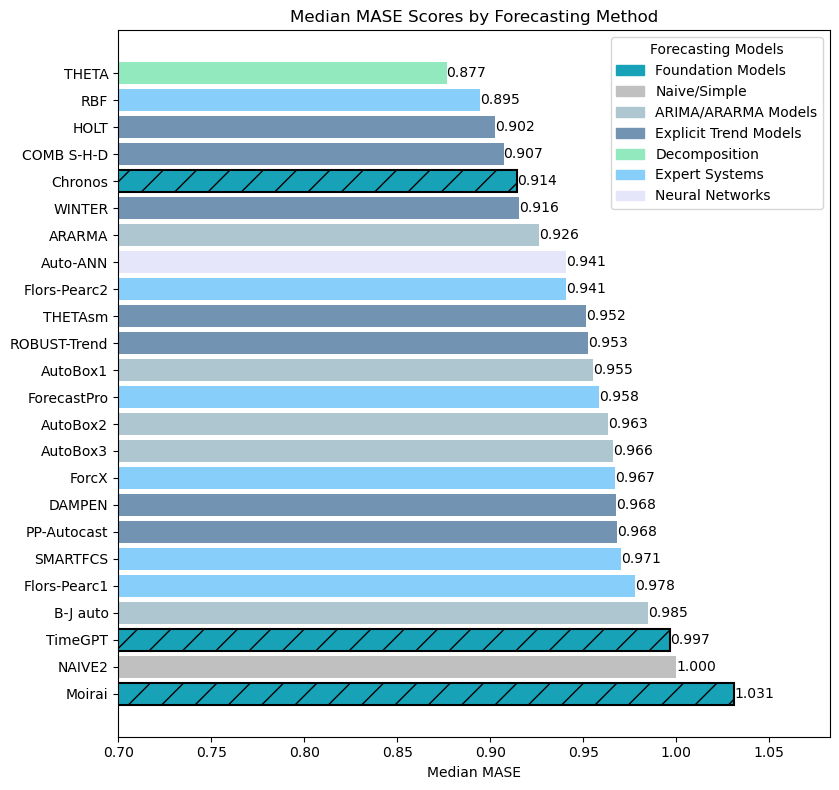

In [11]:
category_colors = median_mase_df['Category'].map(color_map)

plt.figure(figsize=(10, 8))
bars = plt.barh(median_mase_df['Method'], median_mase_df['MedianMASE'], color=category_colors)

transformer_bars = [bar for bar, method in zip(bars, median_mase_df['Method']) if median_mase_df.loc[median_mase_df['Method'] == method, 'Category'].values[0] == 'Foundation Models']
for bar in transformer_bars:
    bar.set_edgecolor('black')  # Adding a black border to the bar
    bar.set_linewidth(1.5)  # Making the border thicker
    bar.set_hatch('/')  # Adding a hatch pattern

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center', ha='left')

plt.xlabel('Median MASE')
plt.title('Median MASE Scores by Forecasting Method')
plt.gca().invert_yaxis()  # Invert y-axis to have the best method at the top
plt.legend(
    [plt.Rectangle((0,0),1,1, color=color_map[category]) for category in color_map],
    color_map.keys(),
    title="Forecasting Models",
    loc='best'  
)

plt.xlim(left=0.7)
plt.tight_layout(rect=[0,0,0.85,1])  
plt.show()

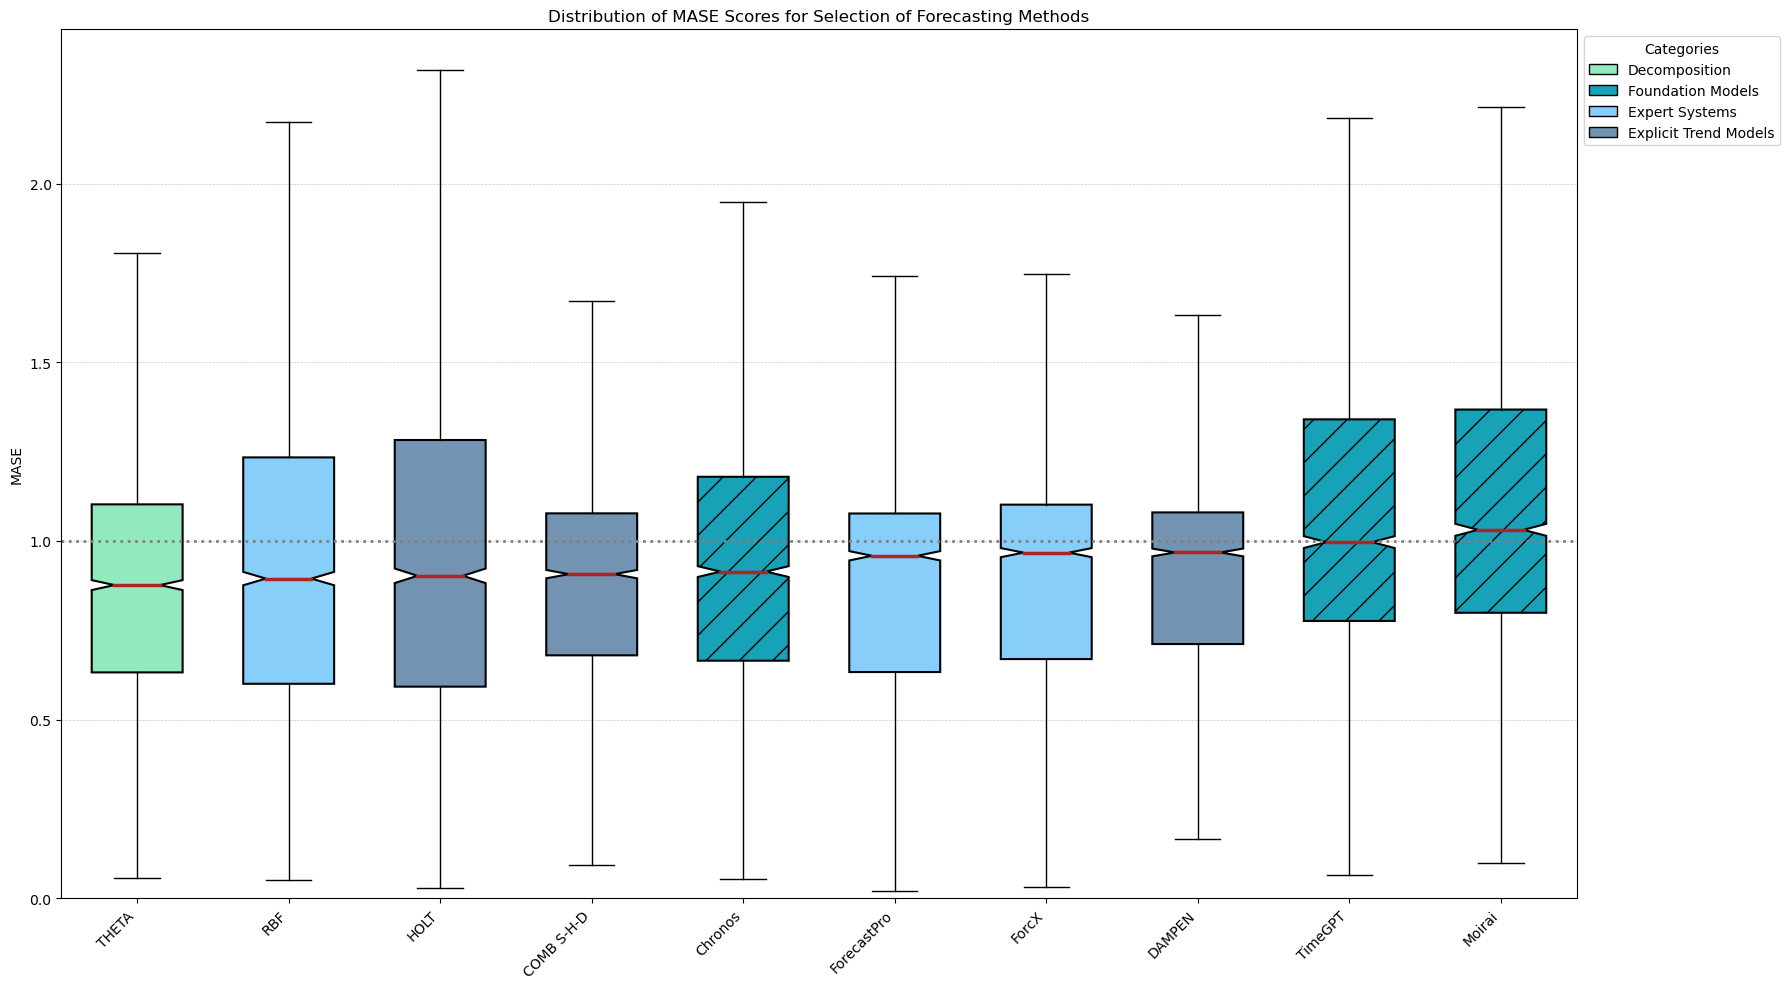

In [12]:
df = mase_df

var_methods = [
            'THETA',
            'ForecastPro',
            'HOLT',
            'ForcX',
            'COMB S-H-D',
            'DAMPEN',
            'RBF',
            'TimeGPT',
            'Chronos',
            'Moirai'
]

df_filtered = df[var_methods]

medians = df_filtered.median().sort_values()

def boxprops(method):
    category = categories_dict[method]
    return {'linestyle': '-', 'linewidth': 2.5, 'color': color_map[category]}

# Define median line properties
medianprops = {'linestyle': '-', 'linewidth': 2.5, 'color': 'firebrick'}

plt.figure(figsize=(18, 10))

used_categories = set()

# Plot each method in the sorted order
for i, method in enumerate(medians.index):
    box = plt.boxplot(df_filtered[method], positions=[i], labels=[method], showfliers=False,
                      boxprops=boxprops(method), medianprops=medianprops, widths=0.6, patch_artist=True, notch=True)
    # Set fill color and highlight if necessary
    category = categories_dict[method]
    used_categories.add(category)  # Add category to set of used categories
    for patch in box['boxes']:
        patch.set_facecolor(color_map[category])
        if category == 'Foundation Models':
            patch.set_edgecolor('black')  # Adding a black border to the box
            patch.set_linewidth(1.5)  # Making the border thicker
            patch.set_hatch('/')  # Adding a hatch pattern
        else:
            patch.set_edgecolor('black')
            patch.set_linewidth(1.5)

plt.xticks(rotation=45, ha='right')

# Set grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y', alpha=0.7)

# Set limits for y-axis
plt.ylim(bottom=0)

# Set labels and title
plt.ylabel('MASE')
plt.title('Distribution of MASE Scores for Selection of Forecasting Methods')

# Benchmark line
plt.axhline(y=1, color='grey', linestyle='dotted', linewidth=2, label='Benchmark')

# Create legend from the color map only for used categories
legend_elements = [Patch(facecolor=color_map[cat], edgecolor='black', label=cat) for cat in used_categories]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title="Categories")

# Layout adjustment and show plot
plt.tight_layout()
plt.show()


In [13]:
categories_dict = {
    'NAIVE2': 'Naive/Simple',
    'SINGLE': 'Naive/Simple',
    'HOLT': 'Explicit Trend Models',
    'ROBUST-Trend': 'Explicit Trend Models',
    'WINTER': 'Explicit Trend Models',
    'DAMPEN': 'Explicit Trend Models',
    'PP-Autocast': 'Explicit Trend Models',
    'THETAsm': 'Explicit Trend Models',
    'COMB S-H-D': 'Explicit Trend Models',
    'THETA': 'Decomposition',
    'B-J auto': 'ARIMA/ARARMA Models',
    'AutoBox1': 'ARIMA/ARARMA Models',
    'AutoBox2': 'ARIMA/ARARMA Models',
    'AutoBox3': 'ARIMA/ARARMA Models',
    'AAM 1': 'ARIMA/ARARMA Models',
    'AAM 2': 'ARIMA/ARARMA Models',
    'ARARMA': 'ARIMA/ARARMA Models',
    'ForecastPro': 'Expert Systems',
    'SMARTFCS': 'Expert Systems',
    'RBF': 'Expert Systems',
    'Flors-Pearc1': 'Expert Systems',
    'Flors-Pearc2': 'Expert Systems',
    'ForcX': 'Expert Systems',
    'Auto-ANN': 'Neural Networks',
    'TimeGPT': 'Foundation Models',
    'Chronos': 'Foundation Models',
    'Moirai': 'Foundation Models'
}

# Transpose the DataFrame
trans_mase_df = mase_df.transpose()

if 'NAIVE2' in trans_mase_df.index:
    # Drop the row where 'NAIVE2' is the value in the 'Method' column
    trans_mase_df.drop('NAIVE2', axis=0, inplace=True)
else:
    print("Row with 'NAIVE2' not found in the transposed DataFrame.")

#trans_mase_df.drop('NAIVE2', axis=0, inplace=True)

# Ensure consistent index
trans_mase_df.reset_index(inplace=True)
trans_mase_df.rename(columns={'index': 'Method'}, inplace=True)

# Calculate statistics
median_scores = trans_mase_df.set_index('Method').median(axis=1).sort_values(ascending=True)  # Sort in ascending order
mean_scores = trans_mase_df.set_index('Method').mean(axis=1)
lower_percentile = trans_mase_df.set_index('Method').quantile(0.25, axis=1)
upper_percentile = trans_mase_df.set_index('Method').quantile(0.75, axis=1)

# Assign ranks
ranking = range(1, len(median_scores) + 1)

# Create DataFrame
ranking_df = pd.DataFrame({
    'Ranking': ranking,
    'Method': median_scores.index,
    'Category': [categories_dict[method] for method in median_scores.index],
    'Median Score': median_scores.values,
    'Mean Score': mean_scores.loc[median_scores.index].values,
    'Lower Percentile': lower_percentile.loc[median_scores.index].values,
    'Upper Percentile': upper_percentile.loc[median_scores.index].values
})

ranking_df.to_csv('mase_ranking.csv')

In [14]:
yearly_results = results_df[results_df['NF'] == 6].copy()
quart_results = results_df[results_df['NF'] == 8].copy()
month_results = results_df[results_df['NF'] == 18].copy()

micro_results = results_df[results_df['Category'] == 'MICRO'].copy()
industry_results = results_df[results_df['Category'] == 'INDUSTRY'].copy()
macro_results = results_df[results_df['Category'] == 'MACRO'].copy()
finance_results = results_df[results_df['Category'] == 'FINANCE'].copy()
demographic_results = results_df[results_df['Category'] == 'DEMOGRAPHIC'].copy()
other_results = results_df[results_df['Category'] == 'OTHER'].copy()

yearly_mase_results = calculate_mase_per_series(yearly_results, 'Actual', forecast_cols, 'NAIVE2')
quart_mase_results = calculate_mase_per_series(quart_results, 'Actual', forecast_cols, 'NAIVE2')
month_mase_results = calculate_mase_per_series(month_results, 'Actual', forecast_cols, 'NAIVE2')

micro_mase_results = calculate_mase_per_series(micro_results, 'Actual', forecast_cols, 'NAIVE2')
industry_mase_results = calculate_mase_per_series(industry_results, 'Actual', forecast_cols, 'NAIVE2')
macro_mase_results = calculate_mase_per_series(macro_results, 'Actual', forecast_cols, 'NAIVE2')
finance_mase_results = calculate_mase_per_series(finance_results, 'Actual', forecast_cols, 'NAIVE2')
demographic_mase_results = calculate_mase_per_series(demographic_results, 'Actual', forecast_cols, 'NAIVE2')
other_mase_results = calculate_mase_per_series(other_results, 'Actual', forecast_cols, 'NAIVE2')

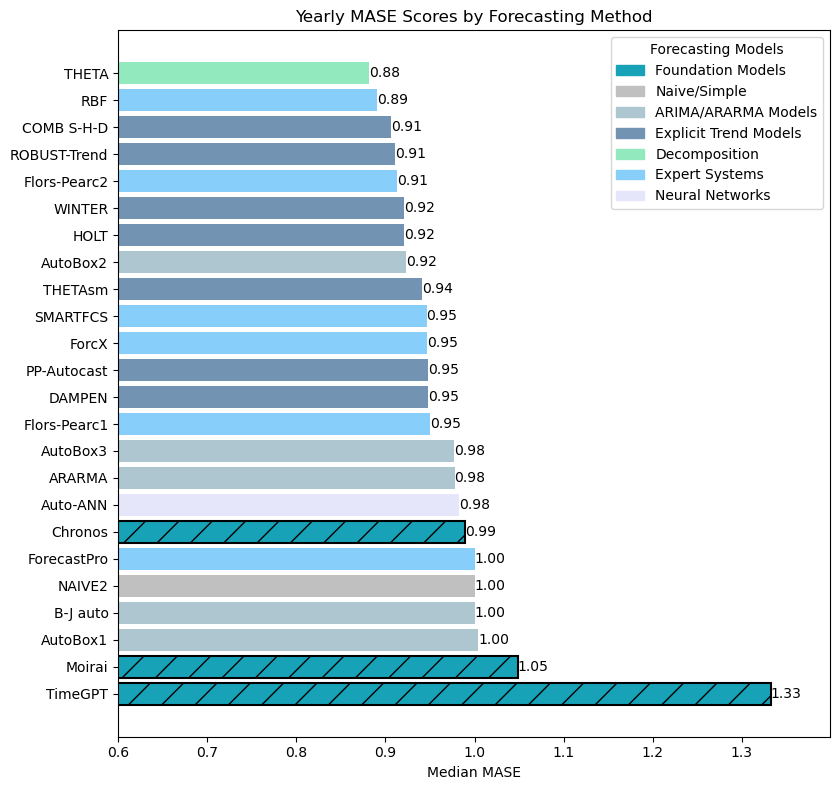

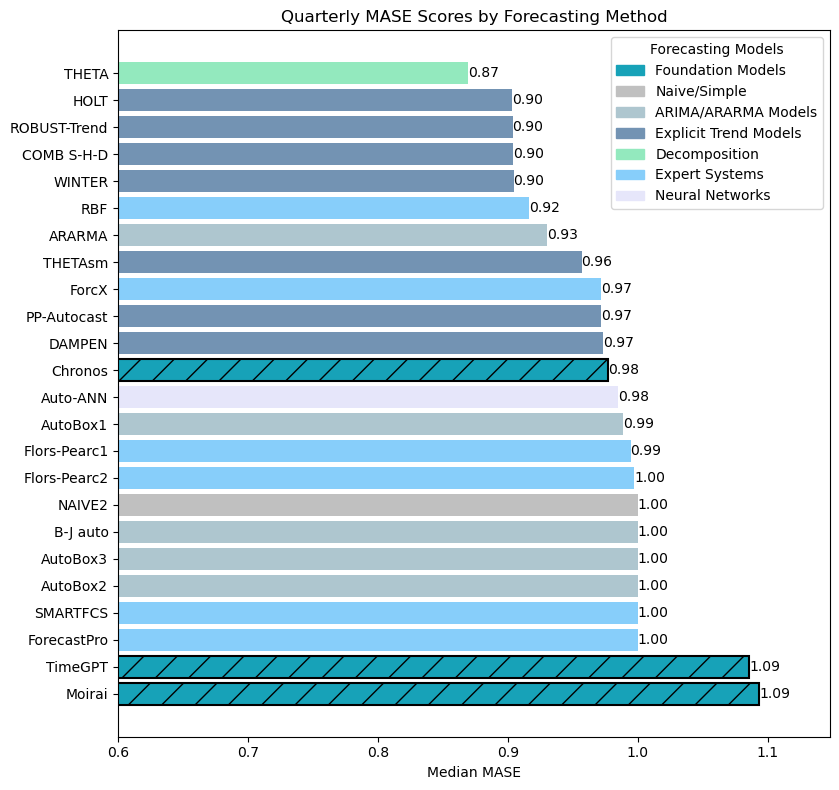

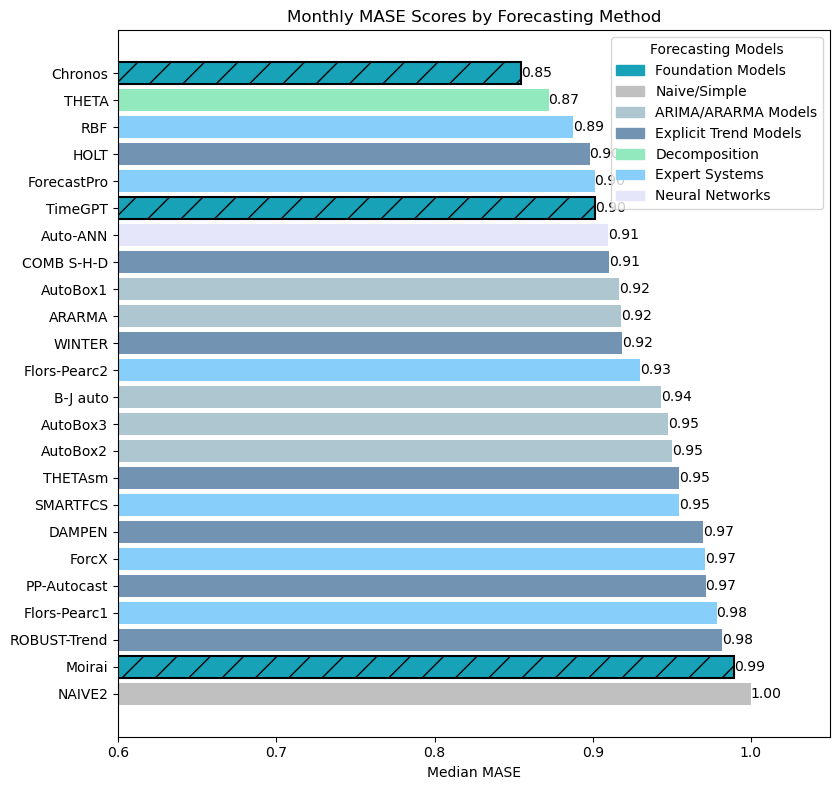

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_mase_results(mase_results, categories_dict, color_map, title="Median MASE Scores by Forecasting Method"):
    mase_df = pd.DataFrame.from_dict(mase_results, orient='index')

    median_mase = mase_df.median().sort_values()
    
    median_mase_df = pd.DataFrame(median_mase, columns=['MedianMASE'])
    median_mase_df = median_mase_df.reset_index()
    median_mase_df.columns = ['Method', 'MedianMASE']
    
    median_mase_df['Category'] = median_mase_df['Method'].map(categories_dict)
    category_colors = median_mase_df['Category'].map(color_map)
    
    plt.figure(figsize=(10, 8))
    bars = plt.barh(median_mase_df['Method'], median_mase_df['MedianMASE'], color=category_colors)
    
    transformer_bars = [bar for bar, method in zip(bars, median_mase_df['Method']) if 'Foundation Models' == median_mase_df.loc[median_mase_df['Method'] == method, 'Category'].values[0]]

    for bar in transformer_bars:
        bar.set_edgecolor('black')
        bar.set_linewidth(1.5)
        bar.set_hatch('/')
    
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', va='center', ha='left')
    
    plt.xlabel('Median MASE')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.legend(
        [plt.Rectangle((0,0),1,1, color=color_map[category]) for category in color_map],
        color_map.keys(),
        title="Forecasting Models",
        loc='best'
    )
    #plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(left=0.6)
    plt.tight_layout(rect=[0,0,0.85,1])
    plt.show()


plot_mase_results(yearly_mase_results, categories_dict, color_map, "Yearly MASE Scores by Forecasting Method")
plot_mase_results(quart_mase_results, categories_dict, color_map, "Quarterly MASE Scores by Forecasting Method")
plot_mase_results(month_mase_results, categories_dict, color_map, "Monthly MASE Scores by Forecasting Method")


In [16]:
# Convert each dictionary to a DataFrame and assign a category
df1 = pd.DataFrame.from_dict(micro_mase_results, orient='index')
df1['Category'] = 'MICRO'

df2 = pd.DataFrame.from_dict(industry_mase_results, orient='index')
df2['Category'] = 'INDUSTRY'

df3 = pd.DataFrame.from_dict(macro_mase_results, orient='index')
df3['Category'] = 'MACRO'

df4 = pd.DataFrame.from_dict(finance_mase_results, orient='index')
df4['Category'] = 'FINANCE'

df5 = pd.DataFrame.from_dict(demographic_mase_results, orient='index')
df5['Category'] = 'DEMOGRAPHIC'

df6 = pd.DataFrame.from_dict(other_mase_results, orient='index')
df6['Category'] = 'OTHER'

var_methods = [
            'THETA',
            'ForecastPro',
            'ForcX',
            'COMB S-H-D',
            'DAMPEN',
            'RBF',
            'TimeGPT',
            'Chronos',
            'Moirai'
]


# Concatenate all DataFrames
full_df = pd.concat([df1, df2, df3, df4, df5, df6])



# Calculate the median and mean for each model by category and round to 2 decimal places
statistics_df = full_df.groupby('Category').agg(['median', 'mean']).round(2)

# Optionally, you can rename the columns for better readability
statistics_df.columns = ['_'.join(col).strip() for col in statistics_df.columns.values]

# Display the statistics DataFrame
display(statistics_df)

,TimeGPT_median,TimeGPT_mean,Chronos_median,Chronos_mean,Moirai_median,Moirai_mean,ARARMA_median,ARARMA_mean,Auto-ANN_median,Auto-ANN_mean,...,ROBUST-Trend_median,ROBUST-Trend_mean,SMARTFCS_median,SMARTFCS_mean,THETA_median,THETA_mean,THETAsm_median,THETAsm_mean,WINTER_median,WINTER_mean
Category,,,,,,,,,,,,,,,,,,,,,
DEMOGRAPHIC,1.11,1.74,0.92,1.14,1.13,1.59,0.93,1.35,0.98,1.31,...,0.92,1.16,1.00,1.27,0.87,1.15,0.90,1.01,0.95,1.49
FINANCE,0.97,1.05,0.98,1.05,1.02,1.17,0.95,1.28,0.98,1.18,...,0.98,1.12,1.00,1.26,0.91,1.05,0.99,1.06,0.95,1.15
INDUSTRY,0.99,1.16,0.97,1.05,1.13,1.39,1.01,1.16,1.02,1.21,...,1.00,1.11,1.00,1.20,0.95,1.02,0.98,1.04,0.99,1.15
MACRO,1.02,1.25,0.86,1.10,1.02,1.24,0.76,1.15,0.92,1.17,...,0.70,1.09,0.99,1.25,0.82,0.96,0.95,0.99,0.78,1.23
MICRO,0.97,1.09,0.88,0.96,0.98,1.10,0.99,1.39,0.90,1.03,...,1.04,1.24,0.89,1.09,0.85,1.02,0.95,0.98,0.92,1.31
OTHER,0.85,0.87,0.88,0.85,0.88,0.99,0.72,0.77,0.89,1.50,...,0.86,1.45,0.87,0.95,0.84,0.76,0.94,0.91,0.86,0.94


In [17]:
data_dict = {
    'MICRO': micro_mase_results,
    'DEMOGRAPHIC': demographic_mase_results,
    'FINANCE': finance_mase_results,
    'INDUSTRY': industry_mase_results,
    'MACRO': macro_mase_results,
    'OTHER': other_mase_results
}


other_columns = ['Category']


var_methods = [
            'Chronos',
            'TimeGPT',
            'Moirai'
]

selected_columns = var_methods + other_columns


res_df = pd.DataFrame()

for category, mase_results in data_dict.items():
    mase_results_df = pd.DataFrame.from_dict(mase_results, orient='index')
    mase_results_df['Category'] = category
    res_df = pd.concat([res_df, mase_results_df])

res_df = res_df[selected_columns]

res_df=res_df.sort_index(ascending=True)

horizon = np.where(res_df.index <= 646, 'YEARLY',
                   np.where(res_df.index <= 1402, 'QUART', 'MONTH'))

res_df['Horizon'] = horizon

statistics_df = res_df.groupby(['Horizon', 'Category']).agg(['median', 'mean']).round(2)

statistics_df.to_csv('statistics.csv')


display(statistics_df)


Chronos       TimeGPT       Moirai      
                     median  mean  median  mean median  mean
Horizon Category                                            
MONTH   DEMOGRAPHIC    0.87  1.16    0.95  0.97   1.11  1.21
        FINANCE        0.86  0.92    0.87  0.85   0.98  1.07
        INDUSTRY       0.98  1.05    0.93  1.01   1.11  1.19
        MACRO          0.79  0.98    0.91  0.98   1.03  1.18
        MICRO          0.79  0.82    0.88  0.88   0.92  0.93
        OTHER          0.80  0.84    0.83  0.85   0.88  1.02
QUART   DEMOGRAPHIC    1.06  1.11    0.99  1.26   1.05  1.41
        FINANCE        1.02  1.12    1.01  1.21   1.05  1.10
        INDUSTRY       0.96  1.06    1.13  1.45   1.28  1.56
        MACRO          0.95  1.25    1.11  1.36   1.04  1.33
        MICRO          0.97  1.09    1.09  1.31   1.15  1.38
YEARLY  DEMOGRAPHIC    0.93  1.14    1.51  2.20   1.18  1.80
        FINANCE        1.06  1.28    1.13  1.32   1.06  1.49
        INDUSTRY       0.95  1.08    1.15  1.43   1.10  1.87
        MACRO          1.02  0.95    1.73  1.84   0.95  1.07
        MICRO          1.01  1.20    1.29  1.45   1.04  1.27
        OTHER          0.99  0.93    0.99  0.98   0.89  0.87

In [18]:
def calculate_percentage_better(group):
    # Calculating the percentage of values below 1
    results = {
        'Chronos_Below_1': (group['Chronos'] < 1).mean(),
        'TimeGPT_Below_1': (group['TimeGPT'] < 1).mean(),
        'Moirai_Below_1': (group['Moirai'] < 1).mean(),
        'Count': group['Chronos'].count()  # Using 'Chronos' just to count rows, could use any column
    }
    return pd.Series(results)

# Group by 'Horizon' and 'Category' and apply the calculation function
percentage_better = res_df.groupby(['Horizon', 'Category']).apply(calculate_percentage_better)

# Formatting the results to percentage and rounding off for the percentages
percentage_better[['Chronos_Below_1', 'TimeGPT_Below_1', 'Moirai_Below_1']] = (percentage_better[['Chronos_Below_1', 'TimeGPT_Below_1', 'Moirai_Below_1']] * 100).round(2)


percentage_better.to_csv('percentage_better.csv')


percentage_better

Chronos_Below_1  TimeGPT_Below_1  Moirai_Below_1  Count
Horizon Category                                                            
MONTH   DEMOGRAPHIC            57.66            61.26           44.14  111.0
        FINANCE                62.07            63.45           53.79  145.0
        INDUSTRY               53.59            59.88           40.72  334.0
        MACRO                  69.55            64.42           46.79  312.0
        MICRO                  75.48            69.13           63.21  473.0
        OTHER                  67.31            67.31           57.69   52.0
QUART   DEMOGRAPHIC            45.61            50.88           45.61   57.0
        FINANCE                46.05            48.68           43.42   76.0
        INDUSTRY               55.42            38.55           26.51   83.0
        MACRO                  53.57            41.96           46.43  336.0
        MICRO                  53.92            39.71           34.80  204.0
YEARLY  DEMOGRAPHIC            55.51            31.84           39.18  245.0
        FINANCE                37.93            34.48           41.38   58.0
        INDUSTRY               57.84            34.31           43.14  102.0
        MACRO                  46.99             7.23           60.24   83.0
        MICRO                  46.26            26.53           46.94  147.0
        OTHER                  63.64            54.55           90.91   11.0

/var/folders/h6/pplgpj2536x9l5zs7z8vmzdm0000gn/T/ipykernel_1122/2787915147.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_scores = res_df.groupby('Category').median().reset_index()


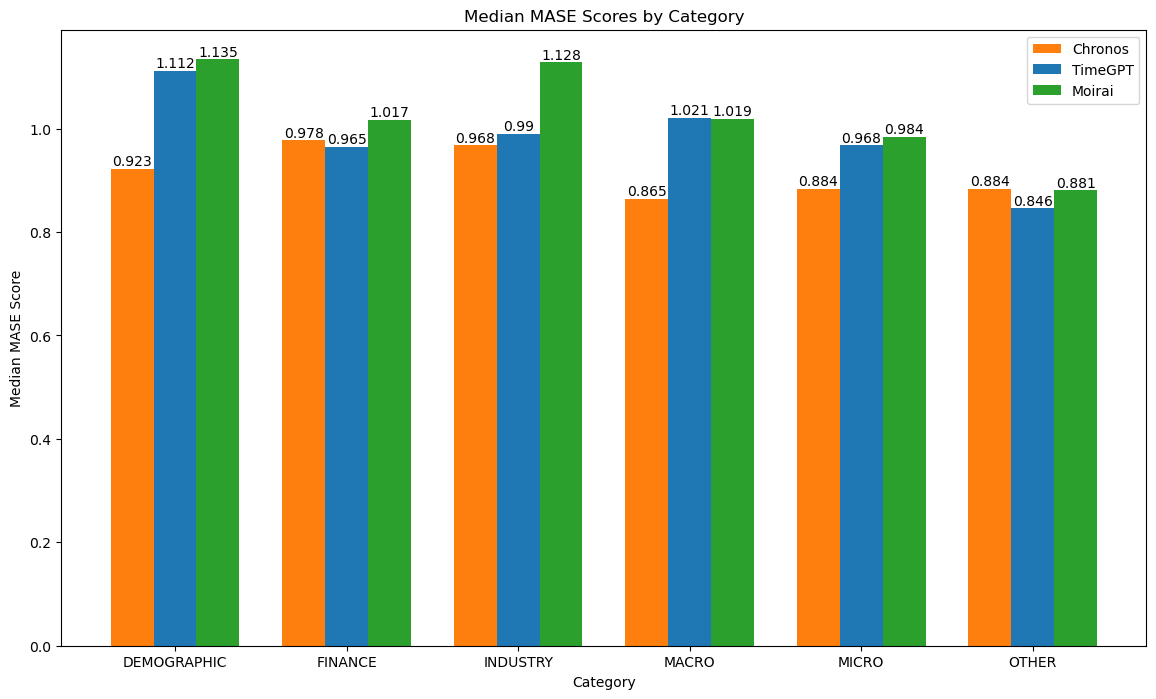

In [19]:

# Calculate median score for each category
median_scores = res_df.groupby('Category').median().reset_index()

categories = median_scores['Category']
chronos_median = median_scores['Chronos']
timegpt_median = median_scores['TimeGPT']
moirai_median = median_scores['Moirai']

x = range(len(categories))

plt.figure(figsize=(14, 8))

# Plotting bars with new color palette
bars1 = plt.bar(x, chronos_median, width=0.25, label='Chronos', color='tab:orange', align='center')
bars2 = plt.bar([p + 0.25 for p in x], timegpt_median, width=0.25, label='TimeGPT', color='tab:blue', align='center')
bars3 = plt.bar([p + 0.5 for p in x], moirai_median, width=0.25, label='Moirai', color='tab:green', align='center')

# Adding data labels
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center') 

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center')

#plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Category')
plt.ylabel('Median MASE Score')
plt.title('Median MASE Scores by Category')
plt.xticks([p + 0.25 for p in x], categories)
plt.legend()

plt.show()


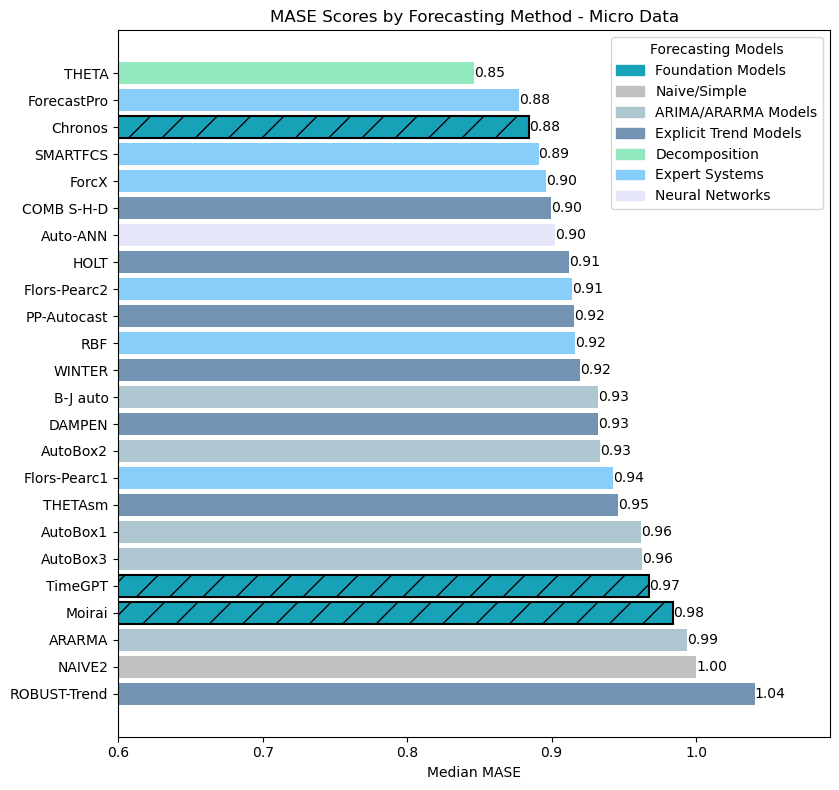

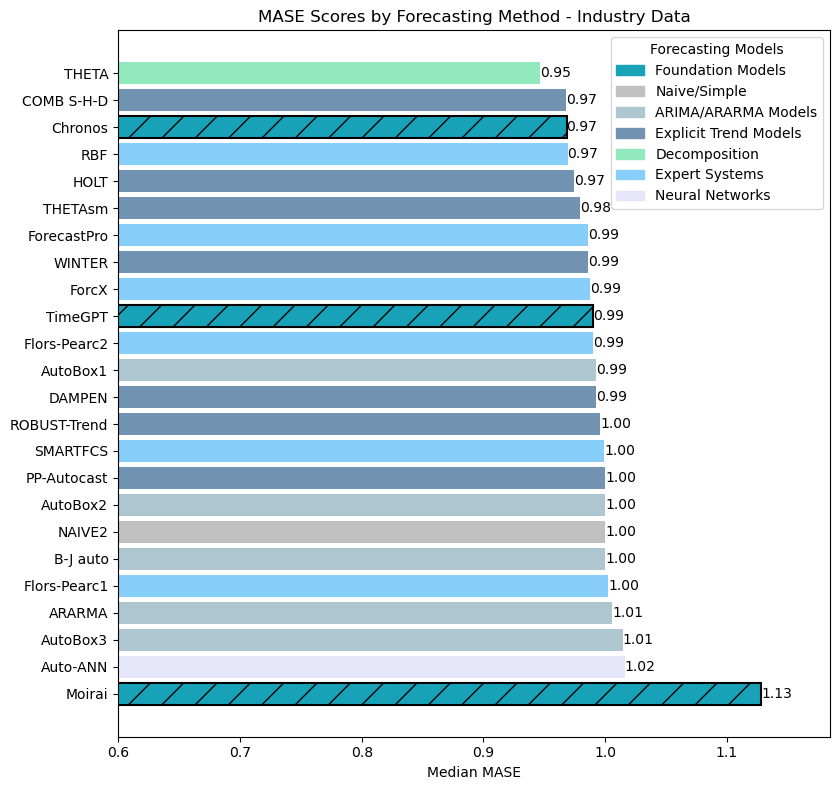

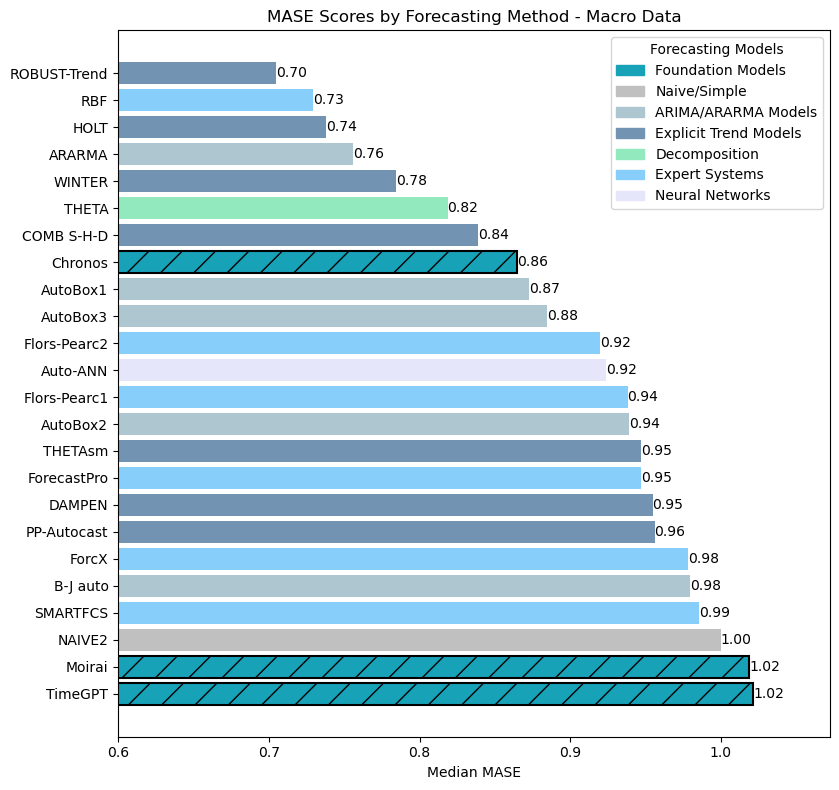

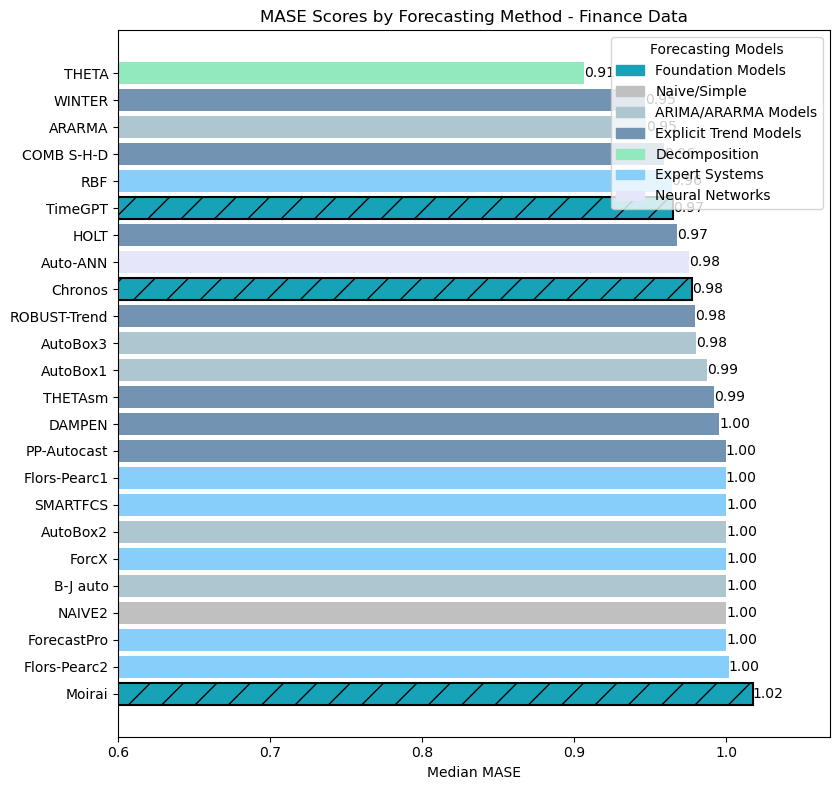

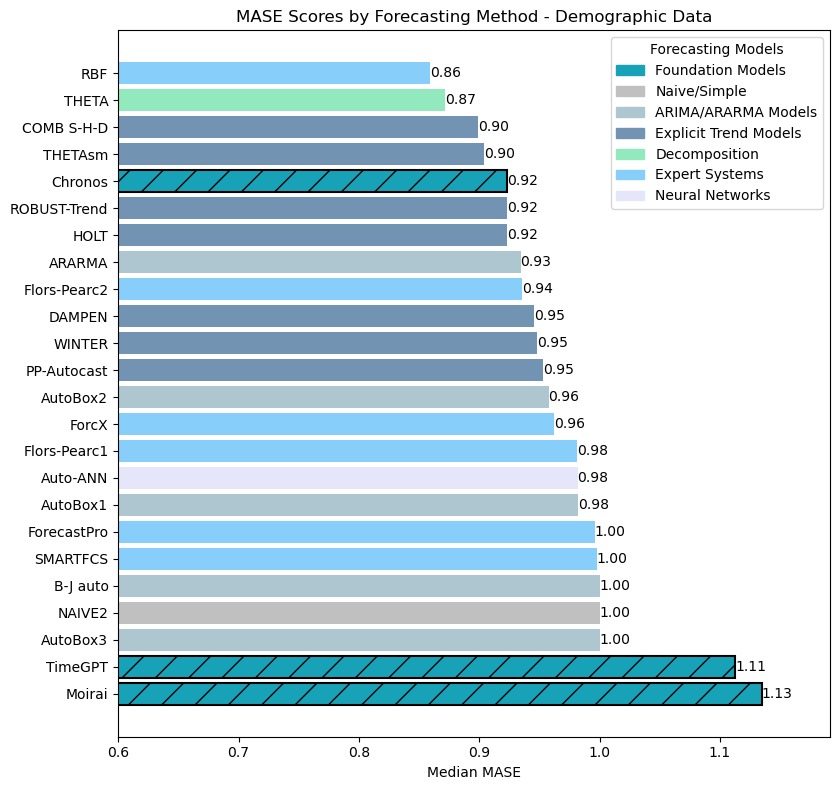

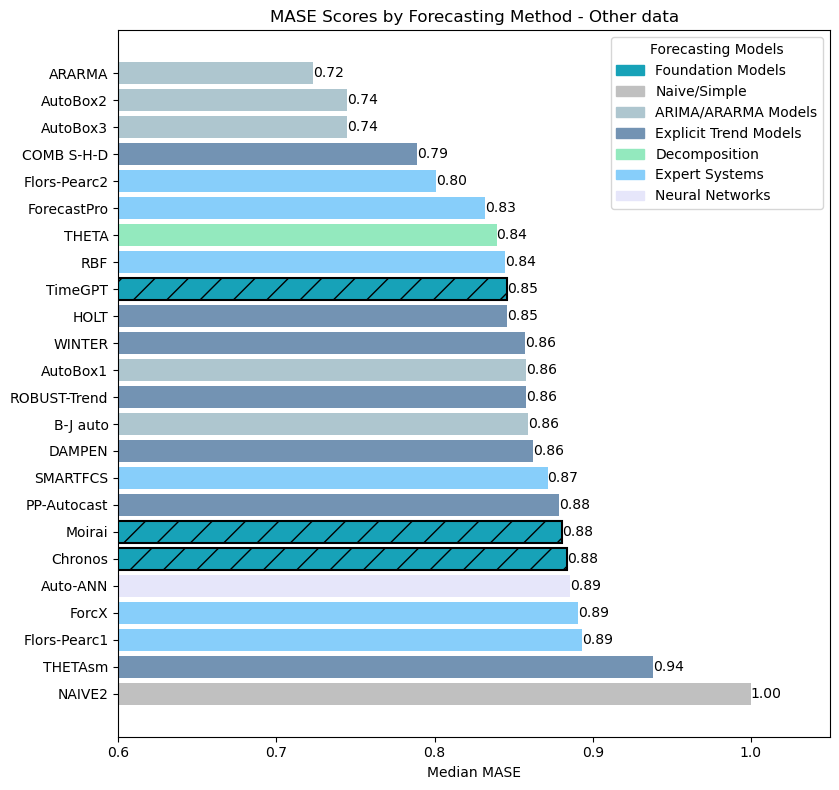

In [20]:
plot_mase_results(micro_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Micro Data")
plot_mase_results(industry_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Industry Data")
plot_mase_results(macro_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Macro Data")
plot_mase_results(finance_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Finance Data")
plot_mase_results(demographic_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Demographic Data")
plot_mase_results(other_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Other data")


# Tests of Results

## ANOVA

For comparing the foundation models, we conduct ANOVA: 

In [71]:
timegpt_mase = res_df['TimeGPT'].sort_index()
chronos_mase = res_df['Chronos'].sort_index()
moirai_mase = res_df['Moirai'].sort_index()



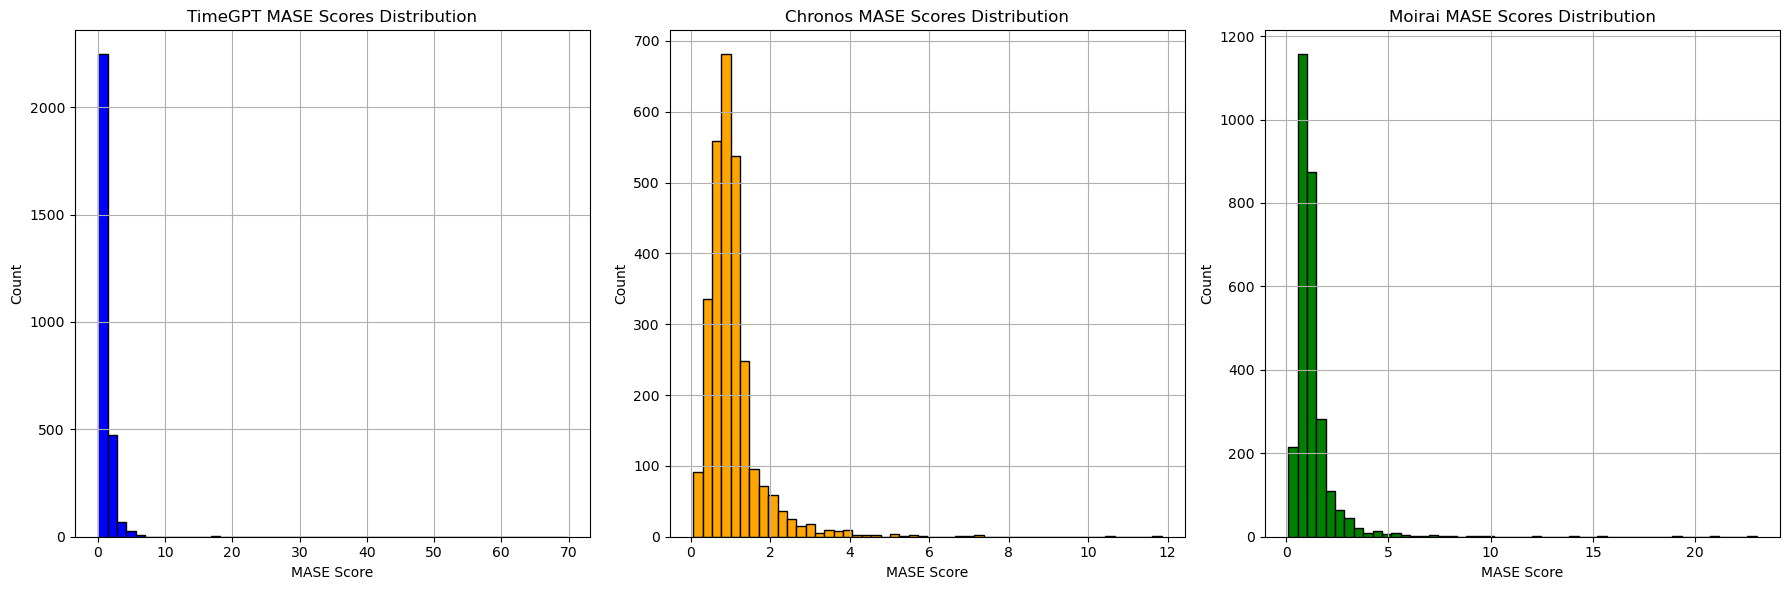

In [69]:
# Plotting the histograms
plt.figure(figsize=(18, 6))

# TimeGPT
plt.subplot(1, 3, 1)
plt.hist(timegpt_mase, bins=50, color='blue', edgecolor='black')
plt.title('TimeGPT MASE Scores Distribution')
plt.xlabel('MASE Score')
plt.ylabel('Count')
plt.grid(True)

# Chronos
plt.subplot(1, 3, 2)
plt.hist(chronos_mase, bins=50, color='orange', edgecolor='black')
plt.title('Chronos MASE Scores Distribution')
plt.xlabel('MASE Score')
plt.ylabel('Count')
plt.grid(True)

# Moirai
plt.subplot(1, 3, 3)
plt.hist(moirai_mase, bins=50, color='green', edgecolor='black')
plt.title('Moirai MASE Scores Distribution')
plt.xlabel('MASE Score')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()

In [62]:
timegpt_mase_array = np.array(timegpt_mase)
chronos_mase_array = np.array(chronos_mase)
moirai_mase_array = np.array(moirai_mase)

# Conduct one-way ANOVA
f_stat, p_value = f_oneway(timegpt_mase, chronos_mase, moirai_mase)

print(f"F-statistic: {f_stat}, p-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference between the models.")
else:
    print("There is no statistically significant difference between the models.")

F-statistic: 26.99017497768537, p-value: 2.067515367713972e-12
There is a statistically significant difference between the models.


### Tukey's HSD Test

In [66]:
df = res_df[['Chronos', 'TimeGPT', 'Moirai']]

df_melted = df.melt(var_name='Model', value_name='MASE')

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df_melted['MASE'], groups=df_melted['Model'], alpha=0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
Chronos  Moirai   0.2188    0.0  0.1437  0.294   True
Chronos TimeGPT   0.1851    0.0  0.1099 0.2602   True
 Moirai TimeGPT  -0.0338 0.5433 -0.1089 0.0414  False
-----------------------------------------------------


## Bootstrap Sampling for Robustness Check

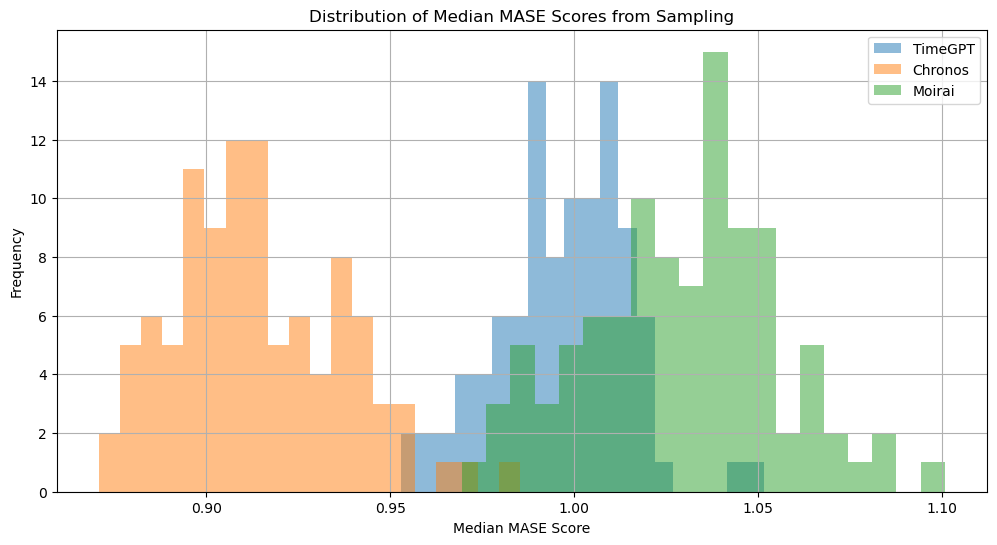

In [83]:
# Number of samples and sample size
n_samples = 100
sample_size = 500  # Adjust based on your actual data size

# Function to perform sampling and compute median MASE scores
def sampling_median_mase(df, n_samples, sample_size, model_names):
    results = {model: [] for model in model_names}
    
    for _ in range(n_samples):
        sample = df.sample(n=sample_size, replace=True)
        
        for model in model_names:
            median_mase = sample[model].median()
            results[model].append(median_mase)
    
    return results

# Perform sampling
model_names = ['TimeGPT', 'Chronos', 'Moirai']
sampling_results = sampling_median_mase(res_df, n_samples, sample_size, model_names)

# Plot the results
plt.figure(figsize=(12, 6))

for model in model_names:
    plt.hist(sampling_results[model], bins=20, alpha=0.5, label=model)

plt.xlabel('Median MASE Score')
plt.ylabel('Frequency')
plt.title('Distribution of Median MASE Scores from Sampling')
plt.legend()
plt.grid(True)
plt.show()